In [33]:
import os
import re
import string
from typing import List, Tuple, Dict
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [34]:
def read_data(file_path: str) -> List[str]:
    """Đọc file txt và trả về list sentences (theo lines để giữ parallel)."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại. Tải từ VLSP hoặc IWSLT.")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip() and not line.startswith('(truncated')]
    
    return lines


print("Đang đọc dữ liệu...")
train_src = read_data('train.vi.txt')
train_tgt = read_data('train.en.txt')
test_src = read_data('public_test.vi.txt')
test_tgt = read_data('public_test.en.txt') 

if len(train_src) != len(train_tgt):
    raise ValueError(f"❌ Train không khớp! Vi: {len(train_src)}, En: {len(train_tgt)}")
if len(test_src) != len(test_tgt):
    raise ValueError(f"❌ Test không khớp! Vi: {len(test_src)}, En: {len(test_tgt)}")
print(f"✅ Dữ liệu đọc thành công! Số câu train: {len(train_src)}, số câu test: {len(test_src)}")


# Báo cáo thống kê
print(f"✅ Train: {len(train_src)} pairs")
print(f"✅ Test: {len(test_src)} pairs")
print(f"Ví dụ Vi: {train_src[0][:100]}...")
print(f"Ví dụ En: {train_tgt[0][:100]}...")

Đang đọc dữ liệu...
✅ Dữ liệu đọc thành công! Số câu train: 500000, số câu test: 3000
✅ Train: 500000 pairs
✅ Test: 3000 pairs
Ví dụ Vi: Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi ...
Ví dụ En: To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at ot...
✅ Dữ liệu đọc thành công! Số câu train: 500000, số câu test: 3000
✅ Train: 500000 pairs
✅ Test: 3000 pairs
Ví dụ Vi: Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi ...
Ví dụ En: To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at ot...


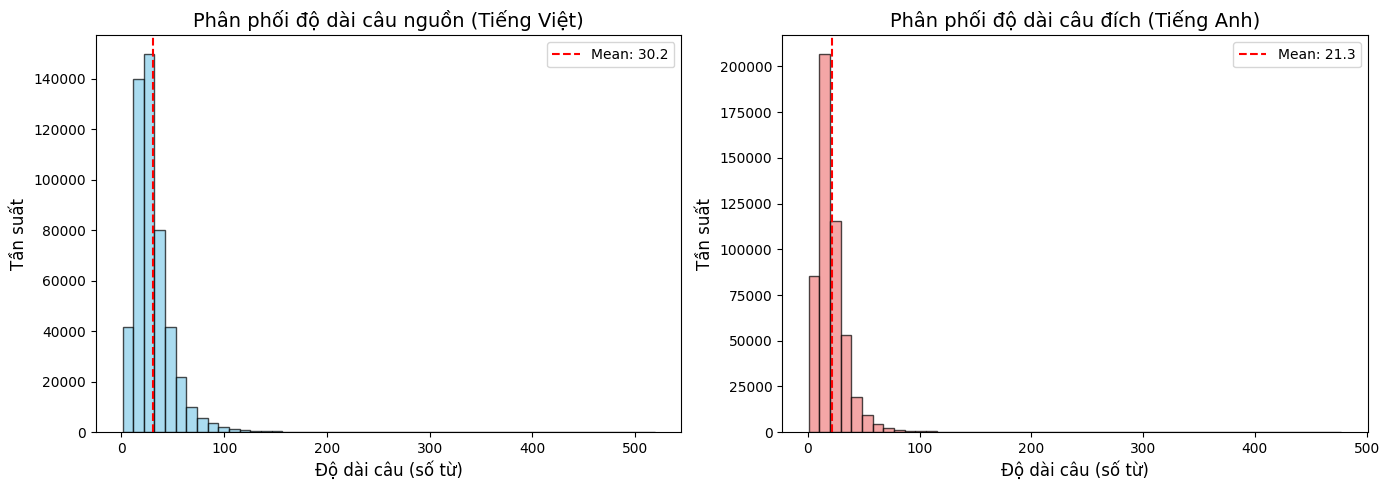

Min/Max src: 1/519
Min/Max tgt: 1/477


In [35]:
# Phân tích độ dài câu gốc (trước khi clean)
src_lengths = [len(s.split()) for s in train_src]
tgt_lengths = [len(t.split()) for t in train_tgt]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram cho source (Vietnamese)
axes[0].hist(src_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[0].set_ylabel('Tần suất', fontsize=12)
axes[0].set_title('Phân phối độ dài câu nguồn (Tiếng Việt)', fontsize=14)
axes[0].axvline(x=sum(src_lengths)/len(src_lengths), color='red', linestyle='--', label=f'Mean: {sum(src_lengths)/len(src_lengths):.1f}')
axes[0].legend()

# Histogram cho target (English)
axes[1].hist(tgt_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[1].set_ylabel('Tần suất', fontsize=12)
axes[1].set_title('Phân phối độ dài câu đích (Tiếng Anh)', fontsize=14)
axes[1].axvline(x=sum(tgt_lengths)/len(tgt_lengths), color='red', linestyle='--', label=f'Mean: {sum(tgt_lengths)/len(tgt_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('length_distribution_raw.png', dpi=150)
plt.show()

print(f"Min/Max src: {min(src_lengths)}/{max(src_lengths)}")
print(f"Min/Max tgt: {min(tgt_lengths)}/{max(tgt_lengths)}")

In [36]:
def clean_sentence(sentence: str) -> str:
    """Làm sạch: lowercase, remove punctuation (giữ numbers cho y tế), strip spaces."""
    sentence = sentence.lower()
    # Không remove numbers: Chỉ remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentence = re.sub(r'\s+', ' ', sentence)  # Extra spaces
    return sentence.strip()

# Tạo pairs và clean
train_pairs_raw = list(zip(train_src, train_tgt))
test_pairs_raw = list(zip(test_src, test_tgt))
train_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(train_src, train_tgt)]
test_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(test_src, test_tgt)]

# Lọc sentences: min_len=3 words, max_len=100 words
min_len, max_len = 3, 100
train_pairs_filtered = [
    (src, tgt) for src, tgt in train_pairs
    if min_len <= len(src.split()) <= max_len 
    and min_len <= len(tgt.split()) <= max_len
]

test_pairs_filtered = [
    (src, tgt) for src, tgt in test_pairs
    if min_len <= len(src.split()) <= max_len 
    and min_len <= len(tgt.split()) <= max_len
]

train_pairs_filtered = list(dict.fromkeys(train_pairs_filtered))
test_pairs_filtered = list(dict.fromkeys(test_pairs_filtered))
# Báo cáo
print(f"\n📊 Sau khi lọc:")
print(f"   Train: {len(train_pairs_raw)} → {len(train_pairs_filtered)} pairs")
print(f"   Test: {len(test_pairs_raw)} → {len(test_pairs_filtered)} pairs")
print(f"   Loại bỏ: {len(train_pairs_raw) - len(train_pairs_filtered)} train pairs")


📊 Sau khi lọc:
   Train: 500000 → 343059 pairs
   Test: 3000 → 2980 pairs
   Loại bỏ: 156941 train pairs


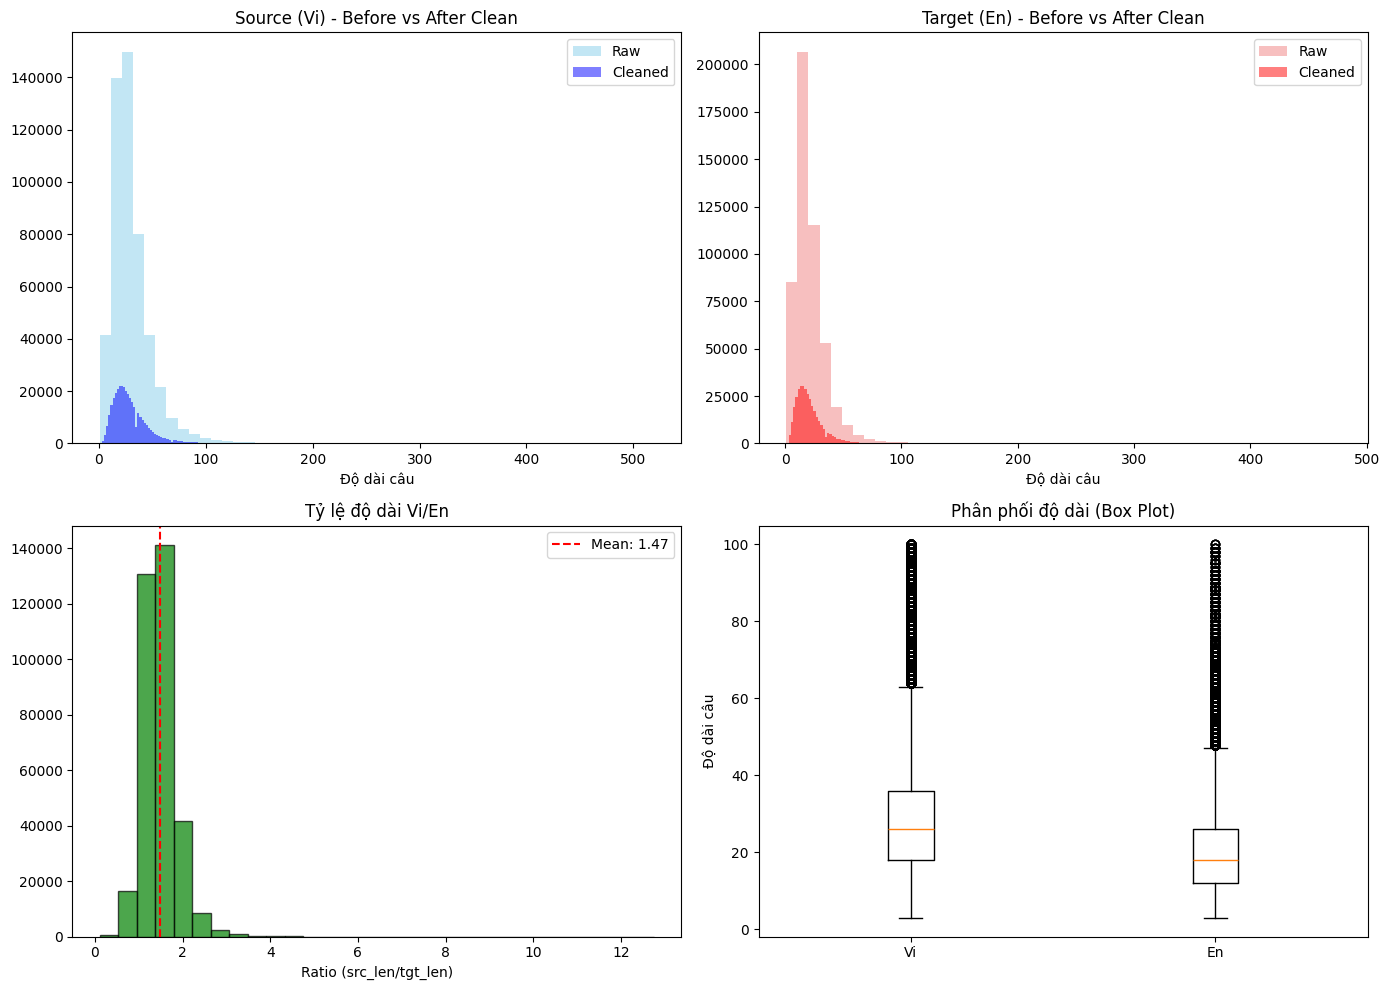

Số câu bị loại: 0 (0.0%)


In [39]:
# Phân phối sau khi clean và filter
src_lengths_clean = [len(s.split()) for s, _ in train_pairs_filtered]
tgt_lengths_clean = [len(t.split()) for _, t in train_pairs_filtered]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# So sánh source
axes[0, 0].hist(src_lengths, bins=50, color='skyblue', alpha=0.5, label='Raw')
axes[0, 0].hist(src_lengths_clean, bins=50, color='blue', alpha=0.5, label='Cleaned')
axes[0, 0].set_title('Source (Vi) - Before vs After Clean')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Độ dài câu')

# So sánh target
axes[0, 1].hist(tgt_lengths, bins=50, color='lightcoral', alpha=0.5, label='Raw')
axes[0, 1].hist(tgt_lengths_clean, bins=50, color='red', alpha=0.5, label='Cleaned')
axes[0, 1].set_title('Target (En) - Before vs After Clean')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Độ dài câu')

# Tỷ lệ độ dài src/tgt
length_ratios = [len(s.split())/len(t.split()) for s, t in train_pairs_filtered]
axes[1, 0].hist(length_ratios, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Tỷ lệ độ dài Vi/En')
axes[1, 0].set_xlabel('Ratio (src_len/tgt_len)')
axes[1, 0].axvline(x=sum(length_ratios)/len(length_ratios), color='red', linestyle='--', 
                    label=f'Mean: {sum(length_ratios)/len(length_ratios):.2f}')
axes[1, 0].legend()

# Box plot so sánh
axes[1, 1].boxplot([src_lengths_clean, tgt_lengths_clean], tick_labels=['Vi', 'En'])
axes[1, 1].set_title('Phân phối độ dài (Box Plot)')
axes[1, 1].set_ylabel('Độ dài câu')

plt.tight_layout()
plt.savefig('length_distribution_cleaned.png', dpi=150)
plt.show()

print(f"Số câu bị loại: {len(train_src) - len(train_pairs)} ({100*(len(train_src)-len(train_pairs))/len(train_src):.1f}%)")

In [41]:
def tokenize(sentence: str) -> List[str]:
    """Tokenize: split words, thêm <SOS> và <EOS>."""
    tokens = sentence.split()
    return ['<SOS>'] + tokens + ['<EOS>']

# Tokenize tất cả
train_src_tokens = [tokenize(src) for src, _ in train_pairs_filtered]
train_tgt_tokens = [tokenize(tgt) for _, tgt in train_pairs_filtered]
test_src_tokens = [tokenize(src) for src, _ in test_pairs_filtered]
test_tgt_tokens = [tokenize(tgt) for _, tgt in test_pairs_filtered]

In [42]:
def build_vocab(tokens_list: List[List[str]], min_freq: int = 2) -> Dict[str, int]:
    """Build vocab from scratch: dict word -> index."""
    counter = Counter()
    for tokens in tokens_list:
        counter.update(tokens)
    
    specials = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']  # Index 0-3
    vocab = {token: idx for idx, token in enumerate(specials)}
    
    for token, freq in counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = len(vocab)
    
    return vocab

# Build (bao gồm test để giảm OOV)
src_vocab = build_vocab(train_src_tokens, min_freq=2)
tgt_vocab = build_vocab(train_tgt_tokens, min_freq=2)

# Báo cáo
print(f"\n📚 Vocabulary:")
print(f"   Source (Vi): {len(src_vocab)} words")
print(f"   Target (En): {len(tgt_vocab)} words")

def count_oov(tokens_list, vocab):
    oov_count = 0
    total_count = 0
    for tokens in tokens_list:
        for token in tokens:
            if token not in ['<SOS>', '<EOS>']:
                total_count += 1
                if token not in vocab:
                    oov_count += 1
    return oov_count, total_count

src_oov, src_total = count_oov(test_src_tokens, src_vocab)
tgt_oov, tgt_total = count_oov(test_tgt_tokens, tgt_vocab)
print(f"   OOV rate (test Vi): {src_oov/src_total*100:.2f}%")
print(f"   OOV rate (test En): {tgt_oov/tgt_total*100:.2f}%")


📚 Vocabulary:
   Source (Vi): 36828 words
   Target (En): 64506 words
   OOV rate (test Vi): 0.51%
   OOV rate (test En): 1.15%


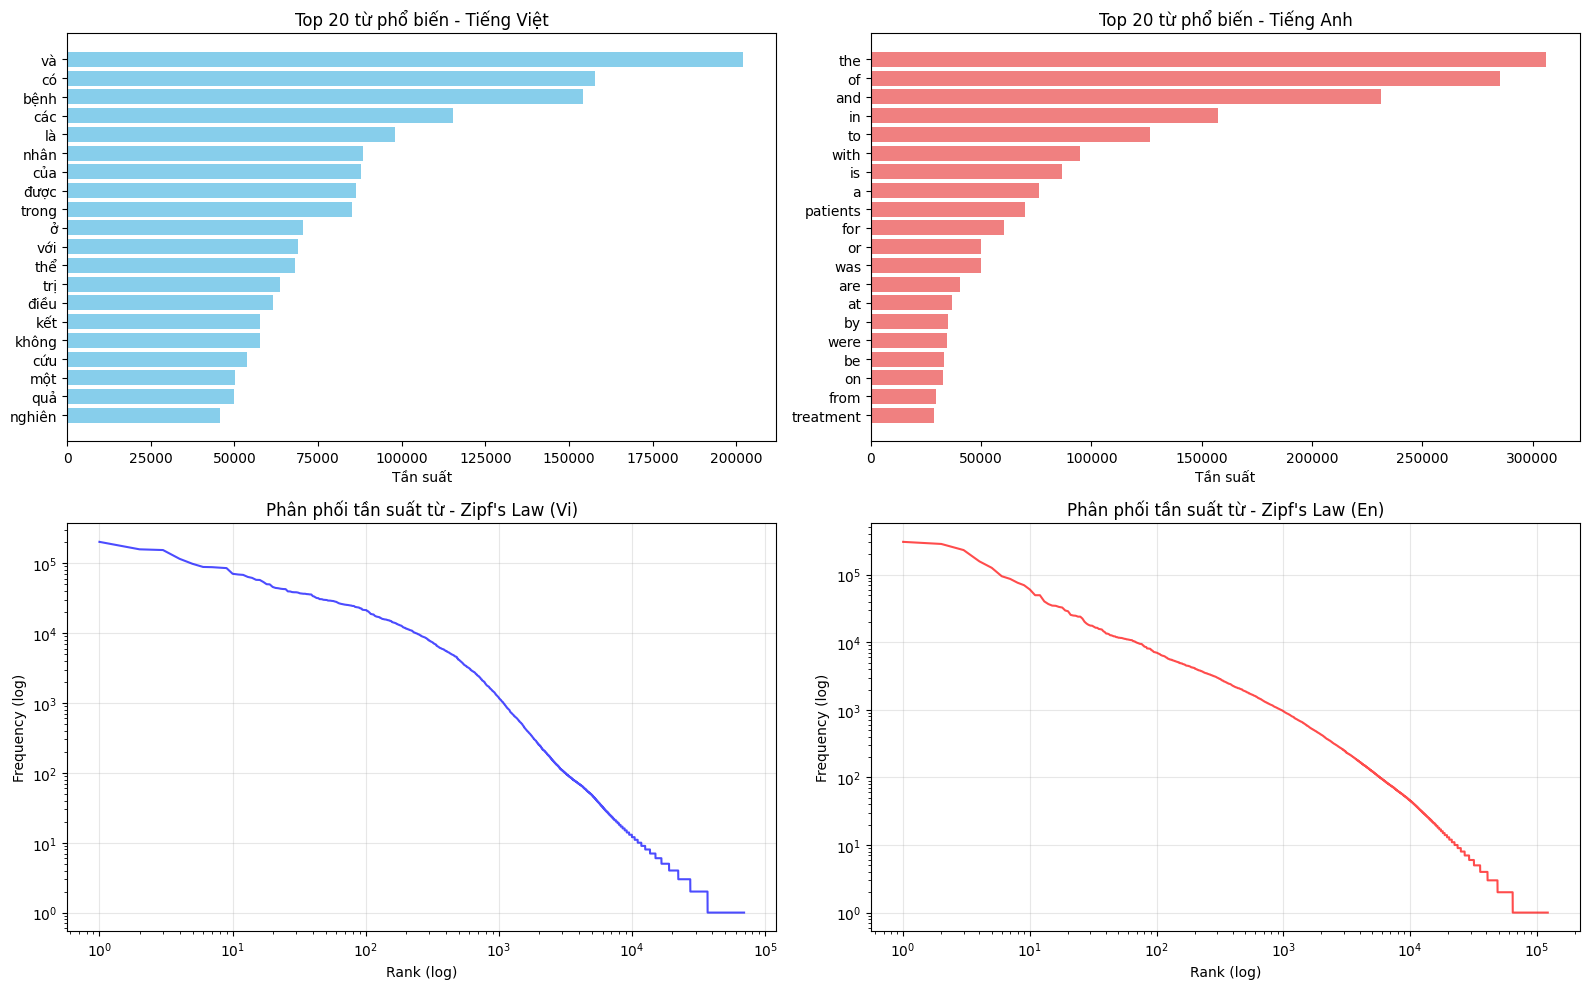


Vocab Coverage Analysis:
Số từ xuất hiện 1 lần (Vi): 32488 (46.9%)
Số từ xuất hiện 1 lần (En): 57600 (47.2%)
Số từ xuất hiện >=5 lần (Vi): 18928
Số từ xuất hiện >=5 lần (En): 35712


In [43]:
# Phân tích vocab
# Đếm tần suất từ trong corpus
src_word_freq = Counter()
for tokens in train_src_tokens:
    src_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

tgt_word_freq = Counter()
for tokens in train_tgt_tokens:
    tgt_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 từ phổ biến - Source
top_src = src_word_freq.most_common(20)
axes[0, 0].barh([w for w, _ in top_src][::-1], [c for _, c in top_src][::-1], color='skyblue')
axes[0, 0].set_title('Top 20 từ phổ biến - Tiếng Việt')
axes[0, 0].set_xlabel('Tần suất')

# Top 20 từ phổ biến - Target
top_tgt = tgt_word_freq.most_common(20)
axes[0, 1].barh([w for w, _ in top_tgt][::-1], [c for _, c in top_tgt][::-1], color='lightcoral')
axes[0, 1].set_title('Top 20 từ phổ biến - Tiếng Anh')
axes[0, 1].set_xlabel('Tần suất')

# Phân phối tần suất từ (log scale)
src_freqs = sorted(src_word_freq.values(), reverse=True)
tgt_freqs = sorted(tgt_word_freq.values(), reverse=True)

axes[1, 0].plot(range(1, len(src_freqs)+1), src_freqs, color='blue', alpha=0.7, label='Vi')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Phân phối tần suất từ - Zipf\'s Law (Vi)')
axes[1, 0].set_xlabel('Rank (log)')
axes[1, 0].set_ylabel('Frequency (log)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(1, len(tgt_freqs)+1), tgt_freqs, color='red', alpha=0.7, label='En')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Phân phối tần suất từ - Zipf\'s Law (En)')
axes[1, 1].set_xlabel('Rank (log)')
axes[1, 1].set_ylabel('Frequency (log)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vocab_distribution.png', dpi=150)
plt.show()

# Báo cáo vocab coverage
print(f"\nVocab Coverage Analysis:")
print(f"Số từ xuất hiện 1 lần (Vi): {sum(1 for f in src_word_freq.values() if f == 1)} ({sum(1 for f in src_word_freq.values() if f == 1)/len(src_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện 1 lần (En): {sum(1 for f in tgt_word_freq.values() if f == 1)} ({sum(1 for f in tgt_word_freq.values() if f == 1)/len(tgt_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện >=5 lần (Vi): {sum(1 for f in src_word_freq.values() if f >= 5)}")
print(f"Số từ xuất hiện >=5 lần (En): {sum(1 for f in tgt_word_freq.values() if f >= 5)}")

In [44]:
def tokens_to_indices(tokens: List[str], vocab: Dict[str, int]) -> torch.Tensor:
    """Chuyển tokens thành tensor indices, dùng <UNK> nếu unknown."""
    unk_idx = vocab.get('<UNK>', 1)
    indices = [vocab.get(token, unk_idx) for token in tokens]
    return torch.tensor(indices, dtype=torch.long)

max_seq_len = 128  # Giới hạn độ dài câu

def pad_truncate_sequences(tokens_list: List[List[str]], vocab: Dict[str, int]) -> torch.Tensor:
    """Truncate và pad sequences thành tensor."""
    indices_list = []
    for tokens in tokens_list:
        if len(tokens) > max_seq_len:
            tokens = tokens[:max_seq_len]  # Truncate
        indices = tokens_to_indices(tokens, vocab)
        indices_list.append(indices)
    
    # Pad với <PAD> (0)
    padded = torch.nn.utils.rnn.pad_sequence(indices_list, batch_first=True, padding_value=vocab['<PAD>'])
    return padded

# Áp dụng
train_src_indices = pad_truncate_sequences(train_src_tokens, src_vocab)
train_tgt_indices = pad_truncate_sequences(train_tgt_tokens, tgt_vocab)
test_src_indices = pad_truncate_sequences(test_src_tokens, src_vocab)
test_tgt_indices = pad_truncate_sequences(test_tgt_tokens, tgt_vocab)


print(f"\n🔢 Tensor shapes:")
print(f"   Train src: {train_src_indices.shape}")
print(f"   Train tgt: {train_tgt_indices.shape}")
print(f"   Test src: {test_src_indices.shape}")
print(f"   Test tgt: {test_tgt_indices.shape}")


🔢 Tensor shapes:
   Train src: torch.Size([343059, 102])
   Train tgt: torch.Size([343059, 102])
   Test src: torch.Size([2980, 101])
   Test tgt: torch.Size([2980, 102])


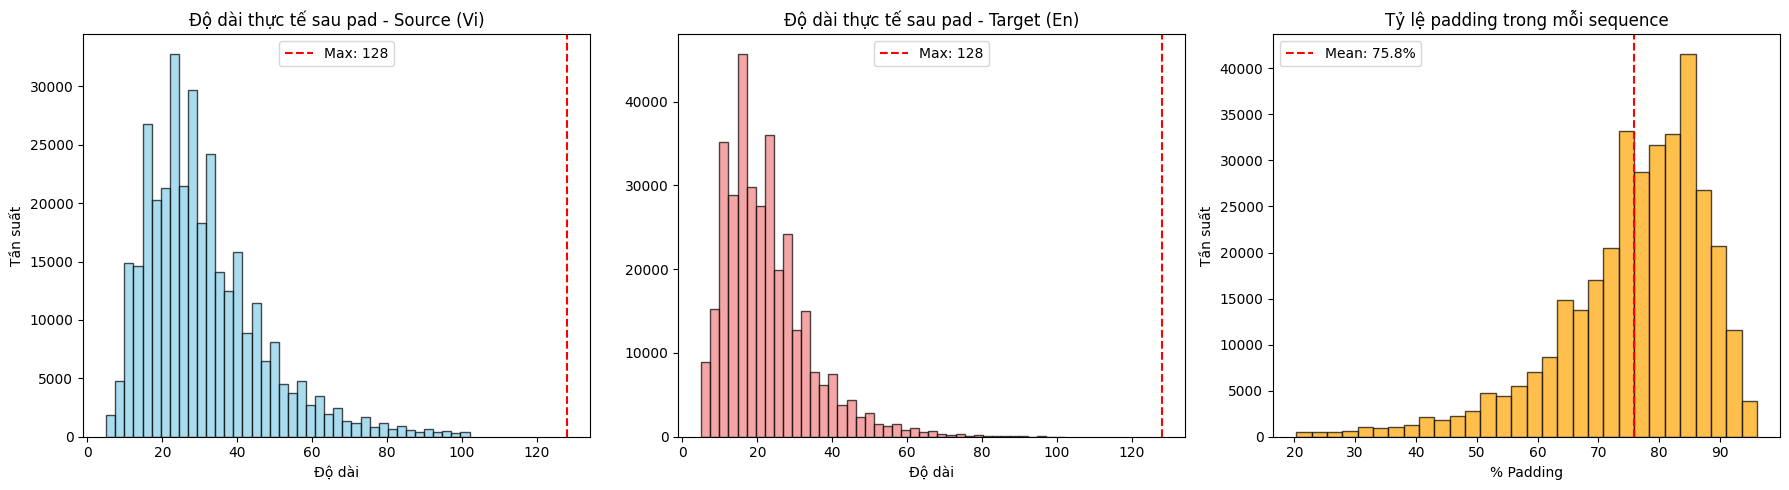

Số câu bị truncate (Vi): 0
Số câu bị truncate (En): 0
Tỷ lệ padding trung bình: 75.8%


In [45]:
# Phân tích sau khi pad/truncate
def get_actual_lengths(padded_tensor, pad_idx=0):
    """Tính độ dài thực (không tính padding)"""
    return [(row != pad_idx).sum().item() for row in padded_tensor]

train_src_actual_lens = get_actual_lengths(train_src_indices)
train_tgt_actual_lens = get_actual_lengths(train_tgt_indices)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Độ dài thực tế sau pad - Source
axes[0].hist(train_src_actual_lens, bins=40, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Độ dài thực tế sau pad - Source (Vi)')
axes[0].set_xlabel('Độ dài')
axes[0].set_ylabel('Tần suất')
axes[0].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[0].legend()

axes[1].hist(train_tgt_actual_lens, bins=40, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Độ dài thực tế sau pad - Target (En)')
axes[1].set_xlabel('Độ dài')
axes[1].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[1].legend()

# Tỷ lệ padding
padding_ratios = [(max_seq_len - actual_len) / max_seq_len * 100 
                  for actual_len in train_src_actual_lens]
axes[2].hist(padding_ratios, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Tỷ lệ padding trong mỗi sequence')
axes[2].set_xlabel('% Padding')
axes[2].set_ylabel('Tần suất')
axes[2].axvline(x=sum(padding_ratios)/len(padding_ratios), color='red', linestyle='--',
                label=f'Mean: {sum(padding_ratios)/len(padding_ratios):.1f}%')
axes[2].legend()

plt.tight_layout()
plt.savefig('padding_analysis.png', dpi=150)
plt.show()

print(f"Số câu bị truncate (Vi): {sum(1 for l in train_src_actual_lens if l >= max_seq_len)}")
print(f"Số câu bị truncate (En): {sum(1 for l in train_tgt_actual_lens if l >= max_seq_len)}")
print(f"Tỷ lệ padding trung bình: {sum(padding_ratios)/len(padding_ratios):.1f}%")

In [47]:
class TranslationDataset(Dataset):
    def __init__(self, src_indices: torch.Tensor, tgt_indices: torch.Tensor):
        self.src = src_indices
        self.tgt = tgt_indices
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# Datasets
train_dataset = TranslationDataset(train_src_indices, train_tgt_indices)
test_dataset = TranslationDataset(test_src_indices, test_tgt_indices)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra batch (báo cáo)
print(f"\n📦 DataLoaders:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")


📦 DataLoaders:
   Train batches: 10721
   Test batches: 94



✅ Đã lưu visualization: data_preprocessing_report.png
✅ Đã lưu báo cáo text: data_preprocessing_report.txt

HOÀN TẤT TIỀN XỬ LÝ DỮ LIỆU!


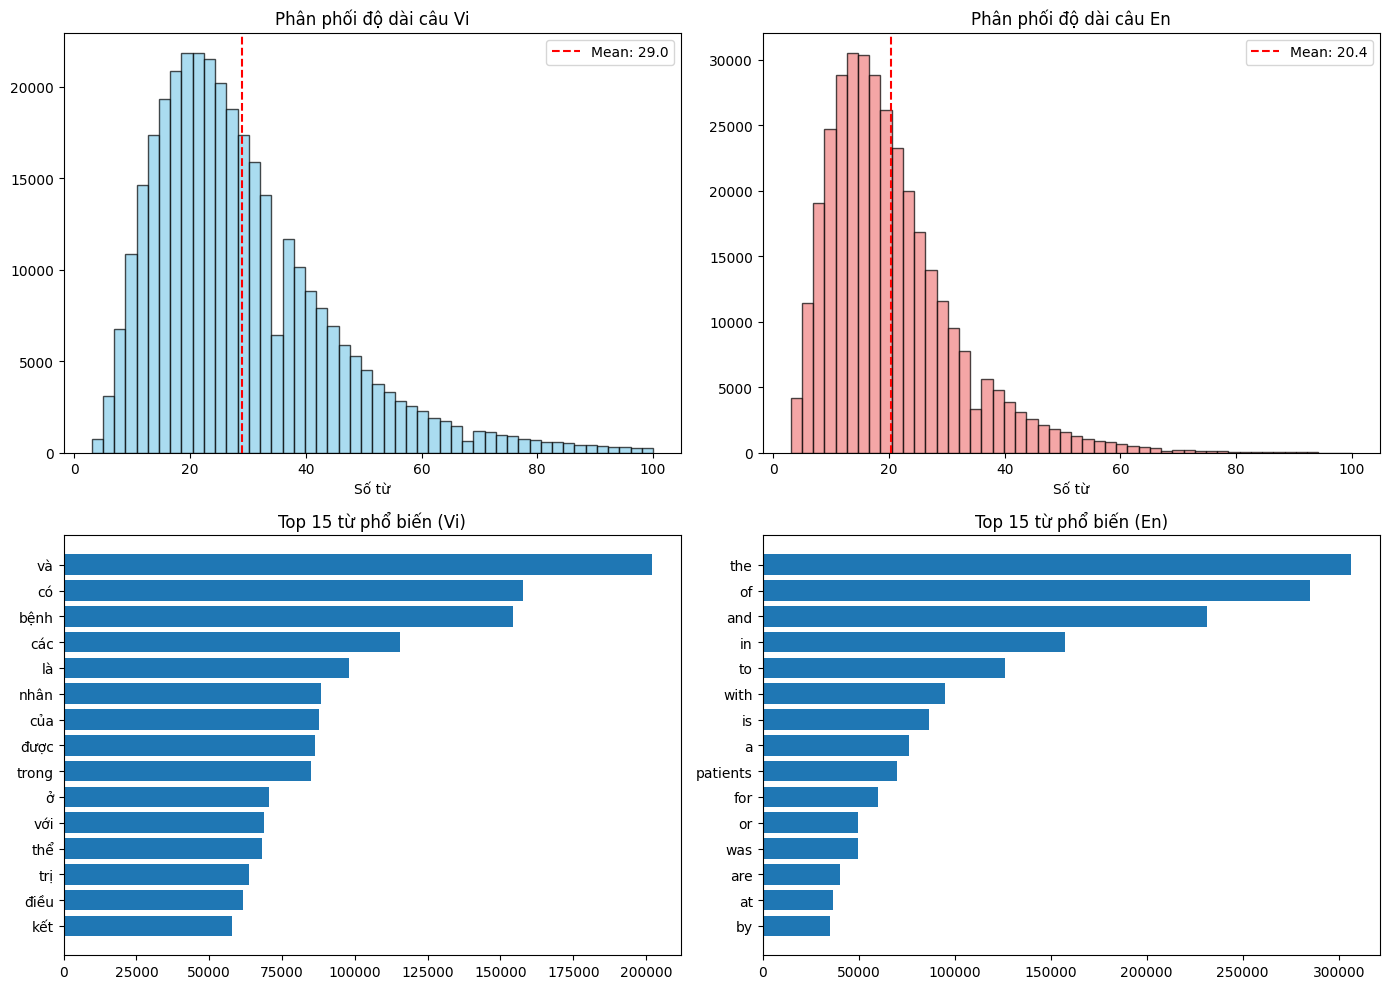

In [48]:
src_lengths = [len(s.split()) for s, _ in train_pairs_filtered]
tgt_lengths = [len(t.split()) for _, t in train_pairs_filtered]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(src_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối độ dài câu Vi')
axes[0, 0].set_xlabel('Số từ')
axes[0, 0].axvline(np.mean(src_lengths), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(src_lengths):.1f}')
axes[0, 0].legend()

axes[0, 1].hist(tgt_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Phân phối độ dài câu En')
axes[0, 1].set_xlabel('Số từ')
axes[0, 1].axvline(np.mean(tgt_lengths), color='red', linestyle='--',
                    label=f'Mean: {np.mean(tgt_lengths):.1f}')
axes[0, 1].legend()

# 8.2. Vocab frequency
src_counter = Counter()
for tokens in train_src_tokens:
    src_counter.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

tgt_counter = Counter()
for tokens in train_tgt_tokens:
    tgt_counter.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

top_src = src_counter.most_common(15)
axes[1, 0].barh([w for w, _ in top_src][::-1], [c for _, c in top_src][::-1])
axes[1, 0].set_title('Top 15 từ phổ biến (Vi)')

top_tgt = tgt_counter.most_common(15)
axes[1, 1].barh([w for w, _ in top_tgt][::-1], [c for _, c in top_tgt][::-1])
axes[1, 1].set_title('Top 15 từ phổ biến (En)')

plt.tight_layout()
plt.savefig('data_preprocessing_report.png', dpi=150, bbox_inches='tight')
print(f"\n✅ Đã lưu visualization: data_preprocessing_report.png")

# 8.3. Text report
with open('data_preprocessing_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("BÁO CÁO TIỀN XỬ LÝ DỮ LIỆU - VIETNAMESE-ENGLISH TRANSLATION\n")
    f.write("="*70 + "\n\n")
    
    f.write("1. NGUỒN DỮ LIỆU:\n")
    f.write(f"   - Train: train.vi.txt & train.en.txt\n")
    f.write(f"   - Test: public_test.vi.txt & public_test.en.txt\n")
    f.write(f"   - Số câu gốc (train): {len(train_pairs_raw)}\n")
    f.write(f"   - Số câu gốc (test): {len(test_pairs_raw)}\n\n")
    
    f.write("2. CÁC BƯỚC TIỀN XỬ LÝ:\n")
    f.write("   a. Làm sạch:\n")
    f.write("      - Lowercase tất cả văn bản\n")
    f.write("      - Loại bỏ dấu câu (giữ số)\n")
    f.write("      - Chuẩn hóa khoảng trắng\n")
    f.write(f"   b. Lọc độ dài: [{min_len}, {max_len}] từ\n")
    f.write(f"      - Số câu loại bỏ: {len(train_pairs_raw) - len(train_pairs_filtered)}\n")
    f.write(f"   c. Loại bỏ duplicates\n")
    f.write(f"   d. Tokenization: space-based + <SOS>/<EOS>\n")
    f.write(f"   e. Padding/Truncation: max_len = {max_seq_len}\n\n")
    
    f.write("3. THỐNG KÊ DỮ LIỆU SAU XỬ LÝ:\n")
    f.write(f"   - Số pairs train: {len(train_pairs_filtered)}\n")
    f.write(f"   - Số pairs test: {len(test_pairs_filtered)}\n")
    f.write(f"   - Độ dài TB Vi: {np.mean(src_lengths):.2f} ± {np.std(src_lengths):.2f}\n")
    f.write(f"   - Độ dài TB En: {np.mean(tgt_lengths):.2f} ± {np.std(tgt_lengths):.2f}\n")
    f.write(f"   - Tỷ lệ Vi/En: {np.mean(src_lengths)/np.mean(tgt_lengths):.2f}\n\n")
    
    f.write("4. TỪ ĐIỂN (VOCABULARY):\n")
    f.write(f"   - Vocab size Vi: {len(src_vocab)}\n")
    f.write(f"   - Vocab size En: {len(tgt_vocab)}\n")
    f.write(f"   - Min frequency: {2}\n")
    f.write(f"   - Special tokens: <PAD>, <UNK>, <SOS>, <EOS>\n")
    f.write(f"   - OOV rate (test Vi): {src_oov/src_total*100:.2f}%\n")
    f.write(f"   - OOV rate (test En): {tgt_oov/tgt_total*100:.2f}%\n")
    f.write(f"   - Top 5 từ Vi: {src_counter.most_common(5)}\n")
    f.write(f"   - Top 5 từ En: {tgt_counter.most_common(5)}\n\n")
    
    f.write("5. DATALOADER:\n")
    f.write(f"   - Batch size: {batch_size}\n")
    f.write(f"   - Train batches: {len(train_loader)}\n")
    f.write(f"   - Test batches: {len(test_loader)}\n")
    f.write(f"   - Shuffle train: True\n\n")
    
    f.write("6. KIỂM TRA CHẤT LƯỢNG:\n")
    f.write(f"   - Không có dòng trống: ✅\n")
    f.write(f"   - Số dòng khớp Vi-En: ✅\n")
    f.write(f"   - Không có duplicates: ✅\n")
    f.write(f"   - Encoding UTF-8: ✅\n")

print(f"✅ Đã lưu báo cáo text: data_preprocessing_report.txt")
print(f"\n{'='*70}")
print(f"HOÀN TẤT TIỀN XỬ LÝ DỮ LIỆU!")
print(f"{'='*70}")